In [1]:
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
from pmdarima import auto_arima
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pylab as plt

In [2]:
bitcoin_df = pd.read_csv('Resources/LTC-USD-monthly.csv',index_col='Date', parse_dates= True)
bitcoin_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,4.32912,4.945860,3.61359,4.07864,4.07864,274656140
2017-02-01,4.07604,4.131660,3.69848,3.77099,3.77099,149051010
2017-03-01,3.77306,7.074540,3.72948,6.66706,6.66706,489000048
2017-04-01,6.65316,16.072701,6.31102,15.70560,15.70560,2678262096
2017-05-01,15.70810,37.328602,14.87570,25.29760,25.29760,6499161804


In [3]:
bitcoin_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
bitcoin_df = bitcoin_df.drop(columns=['Open','High','Low','Adj Close','Volume'])

In [5]:
bitcoin_df.head(10)

,Close
Date,
2017-01-01,4.078640
2017-02-01,3.770990
2017-03-01,6.667060
2017-04-01,15.705600
2017-05-01,25.297600
2017-06-01,40.354301
2017-07-01,43.022701
2017-08-01,71.055099
2017-09-01,55.142399


In [6]:
bitcoin_df.dtypes

Close    float64
dtype: object

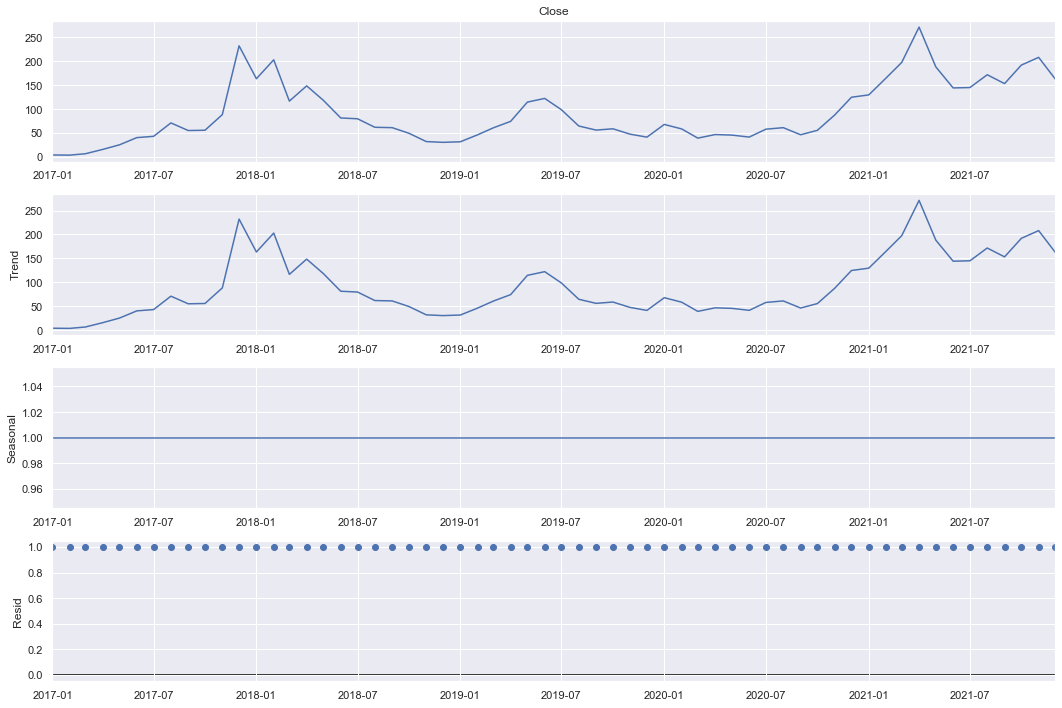

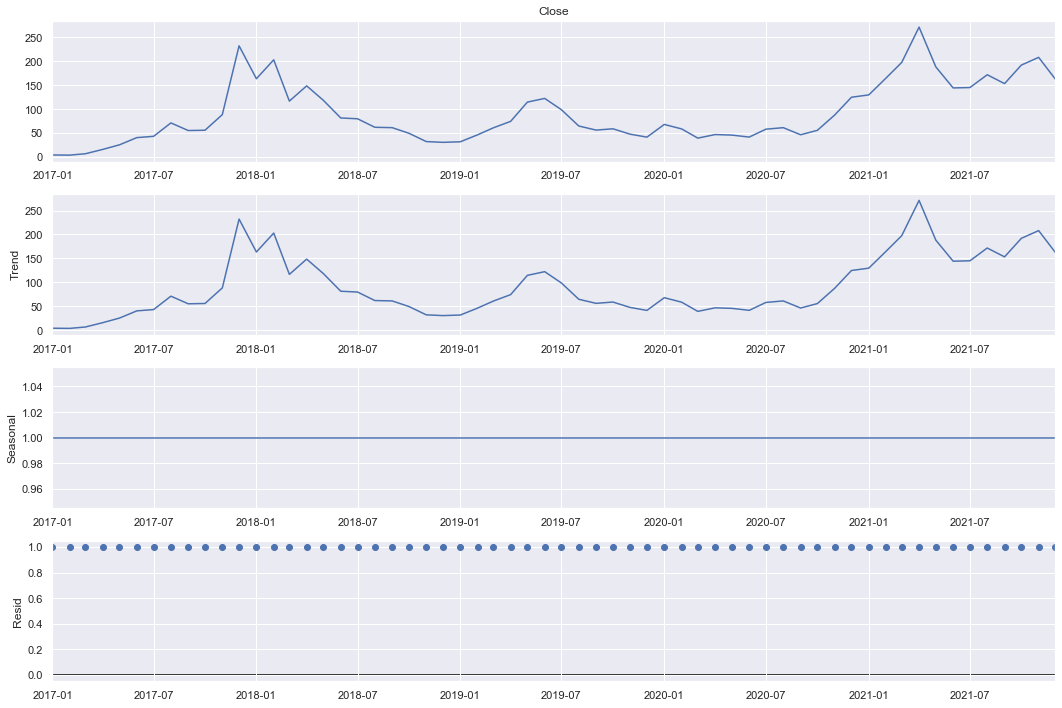

In [7]:
results = seasonal_decompose(bitcoin_df['Close'],model ='multiplicative',period=1)
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

In [8]:
#Arima
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(bitcoin_df['Close'], start_p = 1, start_q = 1,
max_p = 3, max_q = 3, m = 12,
start_P = 0, seasonal = True,
d = None, D = 1, trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True, # we don't want convergence warnings
stepwise = True)# set to stepwise

# To print the summary
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=503.198, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=569.650, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=504.816, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=573.293, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=510.808, Time=0.07 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=504.956, Time=0.24 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=504.656, Time=0.24 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=506.779, Time=0.17 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=501.223, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=508.829, Time=0.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=503.008, Time=0.17 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=502.748, Time=0.23 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -246.611
Date:                              Tue, 07 Dec 2021   AIC                            501.223
Time:                                      23:26:23   BIC                            508.708
Sample:                                           0   HQIC                           504.051
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4359      4.205      1.055      0.291      -3.805      12.677
ar.L1          0.8256      0.089      9.302      0.000       0.652       1.000
ma.S.L12      -0.7551      0.381     -1.983      0.047      -1.501      -0.009
sigma2      1371.9348    481.293      2.851      0.004     428.617    2315.252
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.92   Prob(JB):                         0.20
Heteroskedasticity (H):               0.77   Skew:                            -0.51
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Split data into train / test sets
train = bitcoin_df.iloc[:len(bitcoin_df)-12]
test = bitcoin_df.iloc[len(bitcoin_df)-12:] # set one year(12 months) for testing

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Close'],
order = (0, 1, 1),
seasonal_order =(2, 1, 1, 12))

result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -177.942
Date:                            Tue, 07 Dec 2021   AIC                            365.885
Time:                                    23:26:23   BIC                            373.661
Sample:                                01-01-2017   HQIC                           368.569
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1800      0.202     -0.890      0.374      -0.576       0.216
ar.S.L12      -1.2305      0.163     -7.563      0.000      -1.549      -0.912
ar.S.L24      -0.8355      0.044    -19.094      0.000      -0.921      -0.750
ma.S.L12       0.8369      0.315      2.653      0.008       0.219       1.455
sigma2       655.0955      0.001   1.18e+06      0.000     655.094     655.097
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 5.75
Prob(Q):                              0.58   Prob(JB):                         0.06
Heteroskedasticity (H):               0.28   Skew:                            -0.85
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+21. Standard errors may be unstable.
"""

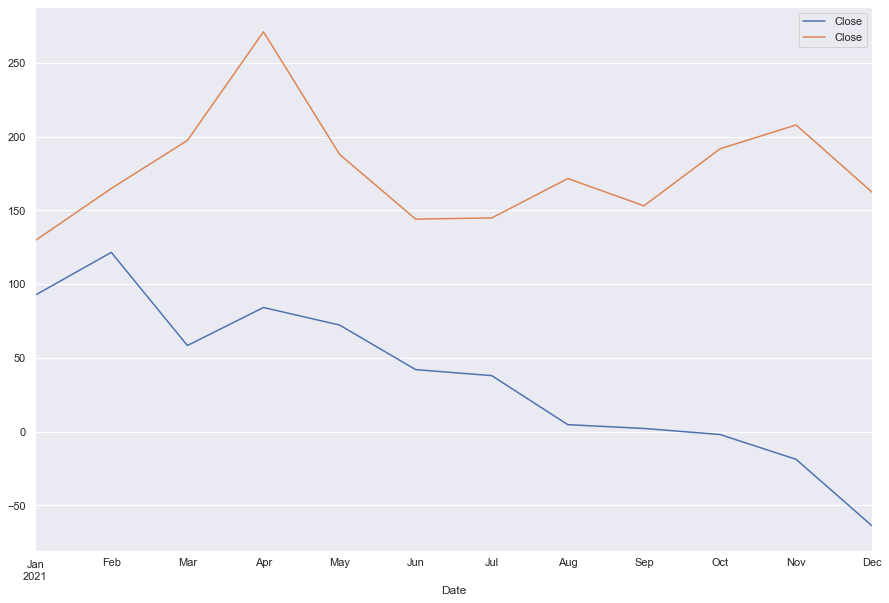

In [10]:
#Predictions of ARIMA Model agains the Test set
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,typ = 'levels').rename("Close")

# plot predictions and actual values
predictions.plot(legend = True)
test['Close'].plot(legend = True)


In [11]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse(test["Close"], predictions)

153.72738785175318

In [12]:
# Calculate mean squared error
mean_squared_error(test["Close"], predictions)

23632.10977572335

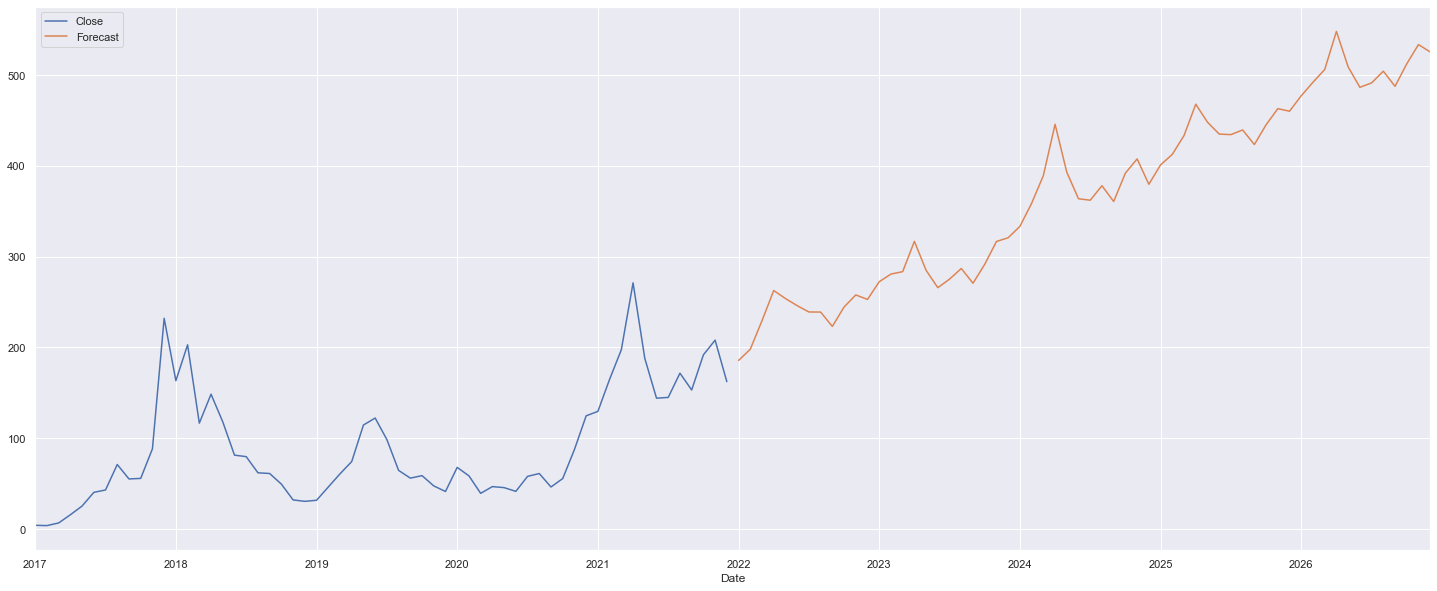

In [13]:
# Train the model on the full dataset
model = model = SARIMAX(bitcoin_df['Close'],order = (0, 1, 1),seasonal_order =(2, 1, 1, 12))
result = model.fit()

# Forecast for the next 20 years
forecast = result.predict(start = len(bitcoin_df),end = (len(bitcoin_df)-1) + 5 * 12,typ = 'levels').rename('Forecast')

# Plot the forecast values
bitcoin_df['Close'].plot(figsize = (25, 10), legend = True)
forecast.plot(legend = True)
